In [4]:
import re
import glob

# Patterns to extract macro/JK/micro steps and CASSCF energies
pattern_steps = re.compile(r'CASSCF converged in\s+(\d+)\s+macro\s+\(\s*(\d+)\s+JK\s+(\d+)\s+micro')
pattern_energy = re.compile(r'CASSCF energy\s*=\s*([-+]?\d*\.\d+(?:[eE][-+]?\d+)?)')


# Gather all log files
log_files = sorted(glob.glob("cas_init_result_avas/log_*.txt"), key=lambda x: int(re.search(r'\d+', x).group()))
results = []

for log_file in log_files:
    with open(log_file, "r") as f:
        lines = f.readlines()

    # Extract steps
    matches_steps = [pattern_steps.search(line) for line in lines if "CASSCF converged" in line]
    matches_steps = [m for m in matches_steps if m]  # filter None
    
    # Extract energies
    matches_energy = [pattern_energy.search(line) for line in lines if "CASSCF energy" in line]
    matches_energy = [m for m in matches_energy if m]

    if len(matches_steps) >= 2 and len(matches_energy) >= 2:
        nn_steps = tuple(map(int, matches_steps[0].groups()))
        avas_steps = tuple(map(int, matches_steps[1].groups()))
        nn_energy = float(matches_energy[0].group(1))
        avas_energy = float(matches_energy[1].group(1))
        results.append((log_file, nn_steps, avas_steps, nn_energy, avas_energy))
    else:
        print(f"Warning: {log_file} missing matches (Steps: {len(matches_steps)}, Energies: {len(matches_energy)})")

# Print results in a formatted table
print(f"{'File':<15} {'NN_macro':>9} {'NN_JK':>6} {'NN_micro':>9} {'NN_energy':>14} | {'AVAS_macro':>9} {'AVAS_JK':>6} {'AVAS_micro':>9} {'AVAS_energy':>14}")
print("-" * 95)
for filename, nn_steps, AVAS_steps, nn_energy, AVAS_energy in results:
    print(f"{filename:<15} {nn_steps[0]:>9} {nn_steps[1]:>6} {nn_steps[2]:>9} {nn_energy:>14.8f} | "
          f"{AVAS_steps[0]:>9} {AVAS_steps[1]:>6} {AVAS_steps[2]:>9} {AVAS_energy:>14.8f}")



File             NN_macro  NN_JK  NN_micro      NN_energy | AVAS_macro AVAS_JK AVAS_micro    AVAS_energy
-----------------------------------------------------------------------------------------------
cas_init_result_avas/log_0.txt         3     49         8     0.03148179 |         7     99        18     0.03148142
cas_init_result_avas/log_1.txt         3     30         7    -1.18668533 |         5     55        12    -1.18669440
cas_init_result_avas/log_2.txt         3     24         8    -1.74915430 |         4     37         9    -1.74915882
cas_init_result_avas/log_3.txt         3     22         7    -2.02128587 |         3     20         6    -2.02128263
cas_init_result_avas/log_4.txt         2     17         5    -2.15180067 |         2     16         5    -2.15180048
cas_init_result_avas/log_5.txt         3     23         7    -2.20865166 |         2     16         5    -2.20865693
cas_init_result_avas/log_6.txt         3     21         7    -2.22548338 |         2     15      

/tmp/ipykernel_146929/1023200983.py:79: UserWarning: Unknown infodict keyword: 'TextAsShapes'. Must be one of {'Subject', 'Author', 'Creator', 'ModDate', 'Keywords', 'Trapped', 'Producer', 'Title', 'CreationDate'}.
  plt.savefig(f'figs/casscf_{fig_titles[i].lower().replace(" ", "_")}.pdf', metadata={"TextAsShapes": False})


E diff [ 3.65974130e-04  9.06623299e-03  4.52255836e-03 -3.24639295e-03
 -1.93999680e-04  5.27172521e-03  2.05187364e-02  4.66637990e-02
  6.51672764e-02  6.31472661e-02  4.74618687e-02  1.13878710e-02
 -6.44901664e-02 -2.05013598e-01 -4.80460543e-01 -9.47074297e-01
 -1.46324689e+00 -1.89151306e+00 -2.25361232e+00 -2.62627745e+00
 -2.81762301e+00  8.65280039e-01  6.33949945e+00]


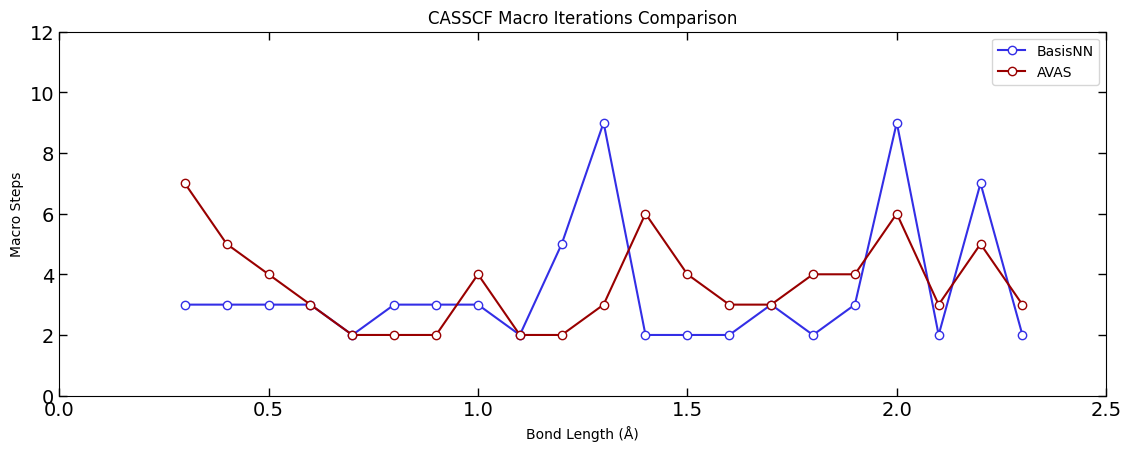

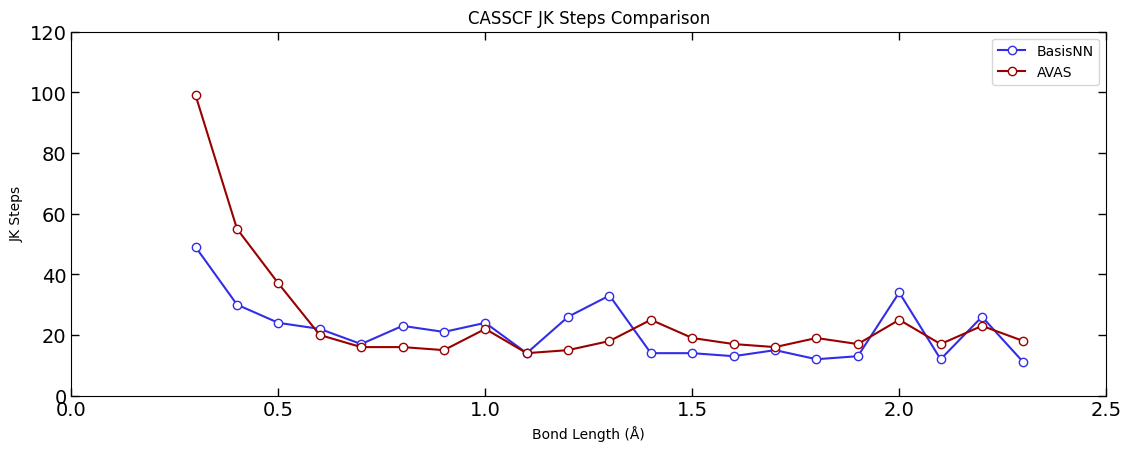

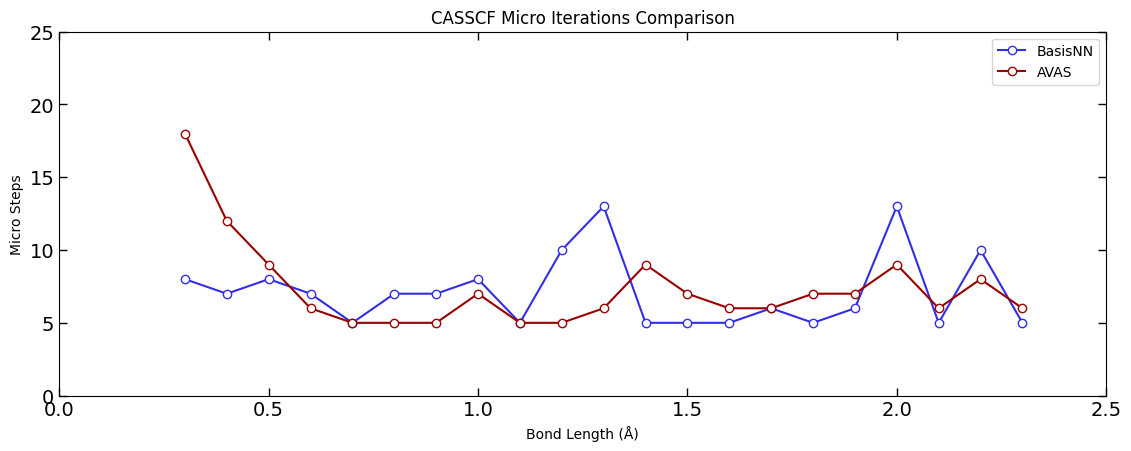

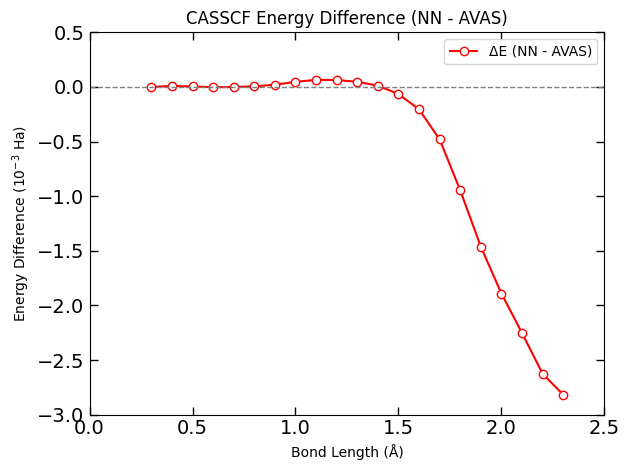

In [5]:
import numpy as np
import re
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

num_chains = 25  # Number of chains
chain_length = 4  # Number of H atoms per chain
bond_length_interval = 0.1
lengths = [bond_length_interval * point for point in range(3, num_chains + 1)]

# Regex patterns
pattern_steps = re.compile(r'CASSCF converged in\s+(\d+)\s+macro\s+\(\s*(\d+)\s+JK\s+(\d+)\s+micro')
pattern_energy = re.compile(r'CASSCF energy\s*=\s*([-+]?\d*\.\d+(?:[eE][-+]?\d+)?)')

# Get and sort log files
log_files = sorted(glob.glob("cas_init_result_avas/log_*.txt"), key=lambda x: int(re.search(r'\d+', x).group()))

# Prepare lists
nn_macro, nn_jk, nn_micro = [], [], []
AVAS_macro, AVAS_jk, AVAS_micro = [], [], []
nn_energy, AVAS_energy = [], []
indices = []

# Extract data from each log
for log_file in log_files:
    with open(log_file, "r") as f:
        lines = f.readlines()

    # Extract steps
    matches_steps = [pattern_steps.search(line) for line in lines if "CASSCF converged" in line]
    matches_steps = [m for m in matches_steps if m]

    # Extract energies
    matches_energy = [pattern_energy.search(line) for line in lines if "CASSCF energy" in line]
    matches_energy = [m for m in matches_energy if m]

    if len(matches_steps) >= 2 and len(matches_energy) >= 2:
        # Steps
        nn_data = tuple(map(int, matches_steps[0].groups()))
        AVAS_data = tuple(map(int, matches_steps[1].groups()))
        nn_macro.append(nn_data[0])
        nn_jk.append(nn_data[1])
        nn_micro.append(nn_data[2])
        AVAS_macro.append(AVAS_data[0])
        AVAS_jk.append(AVAS_data[1])
        AVAS_micro.append(AVAS_data[2])

        # Energies
        nn_energy.append(float(matches_energy[0].group(1)))
        AVAS_energy.append(float(matches_energy[1].group(1)))

        indices.append(int(re.search(r'\d+', log_file).group()))

# Plot step comparisons
fig_titles = ['Macro Iterations', 'JK Steps', 'Micro Iterations']
nn_data_all = [nn_macro, nn_jk, nn_micro]
AVAS_data_all = [AVAS_macro, AVAS_jk, AVAS_micro]
ylabels = ['Macro Steps', 'JK Steps', 'Micro Steps']
y2_l = [12, 120, 25]

# Convert mm to inches
width_in = 58 / 25.4*5
height_in = 23.455 / 25.4*5

for i in range(3):
    plt.figure(figsize=(width_in, height_in))
    plt.plot(lengths[:-2], nn_data_all[i][:-2], label='BasisNN', marker='o', markerfacecolor='white',color=(51/255, 46/255, 230/255))
    plt.plot(lengths[:-2], AVAS_data_all[i][:-2], label='AVAS', marker='o', markerfacecolor='white',color=(153/255, 0/255, 0/255))
    plt.xlabel('Bond Length (Å)')
    plt.ylabel(ylabels[i])
    plt.title(f'CASSCF {fig_titles[i]} Comparison')
    plt.tick_params(axis='both', direction='in', length=6, width=1, labelsize=14, top=True, right=True)
    plt.xlim(0, 2.5)
    plt.ylim(0, y2_l[i])
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'figs/casscf_{fig_titles[i].lower().replace(" ", "_")}.pdf', metadata={"TextAsShapes": False})

# Plot energy difference ΔE = NN - AVAS
energy_diff = np.array([nn - AVAS for nn, AVAS in zip(nn_energy, AVAS_energy)])*1e3
print('E diff',energy_diff)

plt.figure()
plt.plot(lengths[:-2], energy_diff[:-2], label='ΔE (NN - AVAS)', marker='o', markerfacecolor='white', color='red')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Bond Length (Å)')
plt.ylabel('Energy Difference ($10^{-3}$ Ha)')
plt.title('CASSCF Energy Difference (NN - AVAS)')
plt.tick_params(axis='both', direction='in', length=6, width=1, labelsize=14, top=True, right=True)
plt.xlim(0, 2.5)
plt.ylim(-3,0.5)
plt.legend()
plt.tight_layout()
#plt.savefig('figs/casscf_energy_difference.pdf', metadata={"TextAsShapes": False})


Parsed series lengths: {'NN': 3, 'AVAS': 3}
NN macros: [0, 1, 2]
AVAS macros: [0, 1, 2]


/tmp/ipykernel_146929/650682014.py:113: UserWarning: Unknown infodict keyword: 'TextAsShapes'. Must be one of {'Subject', 'Author', 'Creator', 'ModDate', 'Keywords', 'Trapped', 'Producer', 'Title', 'CreationDate'}.
  plt.savefig(f'figs/casscf_convergence.pdf', metadata={"TextAsShapes": False})


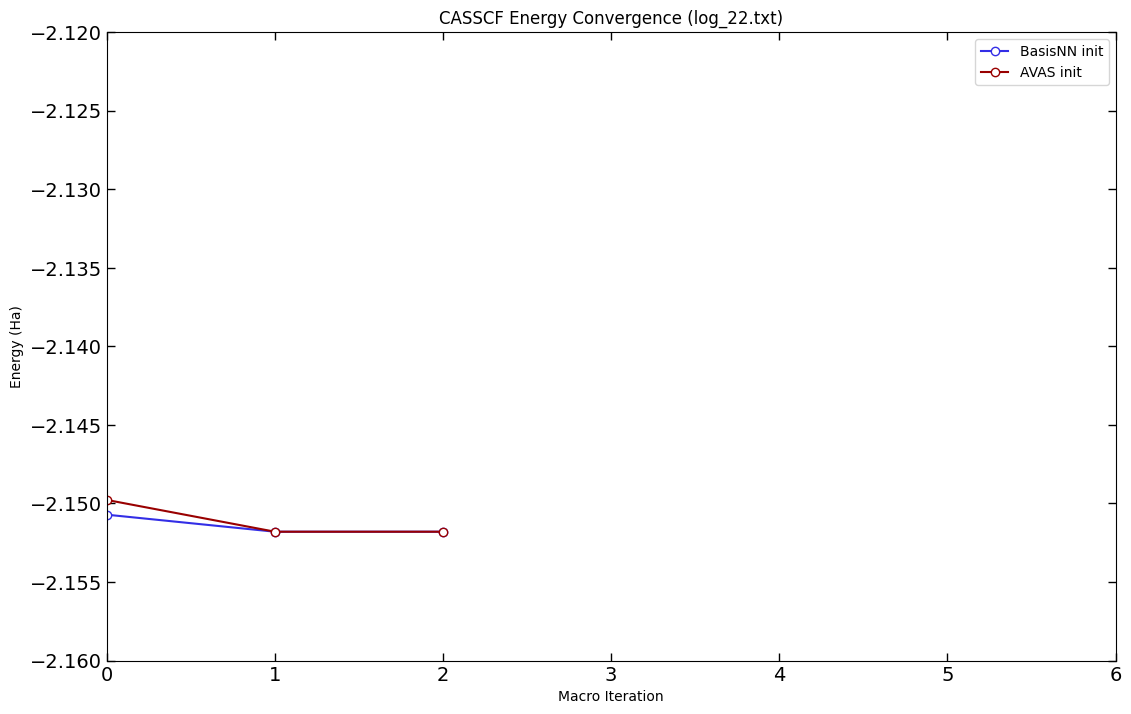

In [8]:
import re
import matplotlib.pyplot as plt

log_file = "cas_init_result_avas/log_4.txt"
with open(log_file, "r") as f:
    text = f.read()

# Split NN vs AVAS blocks
#mark = re.compile(r"Running CASSCF with\s+(NN|AVAS)\s+initial guess", re.I)
mark = re.compile(r"Running CASSCF with\s+(NN|AVAS)[^\n]*?initial guess", re.I)
starts = list(mark.finditer(text))
blocks = []
for i, m in enumerate(starts):
    a = m.end()
    b = starts[i+1].start() if i+1 < len(starts) else len(text)
    blocks.append((m.group(1).upper(), text[a:b]))

NUM = r"[-+]?\d+(?:\.\d+)?(?:[eE][-+]?\d+)?"
re_casci = re.compile(rf"CASCI\s+(?:energy|E)\s*=\s*({NUM})", re.I)
re_casscf_e = re.compile(rf"CASSCF\s+(?:E|energy)\s*=\s*({NUM})", re.I)
re_macro_idx = re.compile(r"macro\s*iter\s*(\d+)", re.I)
re_macro_pair = re.compile(rf"macro\s*iter\s*(\d+).*?CASSCF\s+(?:E|energy)\s*=\s*({NUM})", re.I)
re_converged = re.compile(r"CASSCF\s+converged\s+in\s+(\d+)\s+macro", re.I)

def series_from_block(txt, join_window=8, densify=True):
    mconv = re_converged.search(txt)
    if mconv:
        max_macro = int(mconv.group(1))
        txt_core = txt[:mconv.start()]
    else:
        max_macro = None
        txt_core = txt

    m0 = re_casci.search(txt_core) or re_casci.search(txt)
    if m0:
        E0 = float(m0.group(1))
    else:
        mf = re_casscf_e.search(txt_core) or re_casscf_e.search(txt)
        if not mf:
            return [], []
        E0 = float(mf.group(1))

    macro_to_E = {}

    for k, e in re_macro_pair.findall(txt_core):
        macro_to_E[int(k)] = float(e)    # keep last seen per k

    if not macro_to_E:
        lines = txt_core.splitlines()
        n = len(lines)
        for i, line in enumerate(lines):
            mi = re_macro_idx.search(line)
            if not mi:
                continue
            k = int(mi.group(1))
            E = None
            for j in range(i, min(i + join_window, n)):
                me = re_casscf_e.search(lines[j])
                if me:
                    E = float(me.group(1))
                    break
            if E is not None:
                macro_to_E[k] = E

    if max_macro is not None:
        macro_to_E = {k: v for k, v in macro_to_E.items() if k <= max_macro}

    if not macro_to_E:
        return [0], [E0]

    ks = sorted(macro_to_E)
    xs = [0] + ks
    ys = [E0] + [macro_to_E[k] for k in ks]

    if densify and max_macro is not None:
        full_x = list(range(0, max_macro + 1))
        y_map = dict(zip(xs, ys))
        full_y, last = [], None
        for k in full_x:
            last = y_map.get(k, last if last is not None else E0)
            full_y.append(last)
        return full_x, full_y

    return xs, ys

# Build NN/AVAS series
series = {label: series_from_block(chunk) for label, chunk in blocks}
x_nn, y_nn = series.get("NN", ([], []))
x_AVAS, y_AVAS = series.get("AVAS", ([], []))

print("Parsed series lengths:", {"NN": len(y_nn), "AVAS": len(y_AVAS)})
print("NN macros:", x_nn)
print("AVAS macros:", x_AVAS)

if not y_nn or not y_AVAS:
    raise RuntimeError("Missing energies to plot — check the printed series above.")

width_in = 58 / 25.4*5
height_in = 36.8 / 25.4*5
# Plot against macro iteration numbers
plt.figure(figsize=(width_in, height_in))
plt.plot(x_nn, y_nn, label="BasisNN init",  marker='o', markerfacecolor='white', color=(51/255, 46/255, 230/255))
plt.plot(x_AVAS, y_AVAS, label="AVAS init",      marker='o', markerfacecolor='white', color=(153/255, 0/255, 0/255))
plt.xlabel("Macro Iteration")
plt.ylabel("Energy (Ha)")
plt.title("CASSCF Energy Convergence (log_22.txt)")
plt.xlim(0, 6)
plt.ylim(-2.16,-2.12)
plt.legend()
plt.tick_params(axis='both', direction='in', length=6, width=1, labelsize=14, top=True, right=True)
plt.tight_layout()

plt.savefig(f'figs/casscf_convergence.pdf', metadata={"TextAsShapes": False})
